<a href="https://colab.research.google.com/github/wulanika/deeplearningUAS/blob/main/model_LSTM%2C_GRU%2C_dan_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Perbandingan LSTM, GRU, dan BERT untuk Klasifikasi Sentimen pada Ulasan Produk Tokopedia**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DL

/content/drive/MyDrive/DL


In [ ]:
# =====================================
# 1. INSTALL & IMPORT LIBRARY
# =====================================
!pip install transformers --quiet
!pip install Sastrawi --quiet
!pip install scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel
from torch.optim import AdamW

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# =====================================
# 2. LOAD & CLEAN DATA
# =====================================
!pip install gdown --quiet
import pandas as pd
import gdown

# Ganti dengan file ID milikmu
file_id = "10WIOhPclvvBWVPe7SkMODKU_PvkMr6FO"
output_path = "product_reviews_dirty.csv"

# Unduh file dari Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

# Baca CSV
df = pd.read_csv(output_path)
df.head()


# Ambil kolom 'text' dan 'rating'
df = df[['text', 'rating']]

# Hapus review dengan rating == 3 (netral)
df = df[df['rating'] != 3]

# Ubah rating menjadi label sentimen
# rating >= 4 dianggap positif (1), rating <= 2 dianggap negatif (0)
df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Rename kolom untuk konsistensi
df = df[['text', 'label']]

# Lihat data
df.head()


Downloading...
From: https://drive.google.com/uc?id=10WIOhPclvvBWVPe7SkMODKU_PvkMr6FO
To: /content/drive/MyDrive/DL/product_reviews_dirty.csv
100%|██████████| 10.5M/10.5M [00:00<00:00, 79.7MB/s]


,text,label
0,Barang sesuai pesanan dan cepat sampai,1
1,Barang bagus harga murah,1
2,Paket rapi...mantap....cepat....sampe ke tujuan,1
3,ya saya puas dgn barangnya,1
4,Responya luar biasa b mantap,1


In [ ]:
# =====================================
# 3. PREPROCESSING CEPAT (STEMMING + STOPWORDS)
# =====================================
!pip install swifter --quiet
from tqdm.notebook import tqdm
import swifter
import time

factory = StemmerFactory()
stemmer = factory.create_stemmer()

stopwords = set([
    "yang", "dengan", "untuk", "dan", "di", "ke", "dari", "adalah", "itu", "ini",
    "karena", "sudah", "pada", "juga", "agar", "sebagai", "tidak", "dalam"
])

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|@\w+|[^a-z\s]", " ", text)
    text = " ".join([word for word in text.split() if word not in stopwords])
    return stemmer.stem(text)

tqdm.pandas()
start = time.time()

# Percepat dengan swifter
df['clean_text'] = df['text'].swifter.apply(clean_text)

end = time.time()
print(f"✅ Preprocessing selesai dalam {end - start:.2f} detik")

# Simpan hasil agar tidak ulang
df.to_csv("/content/drive/MyDrive/DL/cleaned_tokopedia_reviews.csv", index=False)
print("📁 Preprocessed data disimpan sebagai 'cleaned_tokopedia_reviews.csv'")


Pandas Apply:   0%|          | 0/38782 [00:00<?, ?it/s]

✅ Preprocessing selesai dalam 1206.34 detik
📁 Preprocessed data disimpan sebagai 'cleaned_tokopedia_reviews.csv'


In [ ]:
# =====================================
# 4. SPLIT DATA
# =====================================
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [ ]:
# =====================================
# 5. TOKENIZATION FOR RNN MODELS (LSTM, GRU)
# =====================================
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

y_train = y_train.values
y_test = y_test.values

In [ ]:
# =====================================
# 6. MODEL DEFINITION: LSTM & GRU (PyTorch)
# =====================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SentimentRNN(nn.Module):
    def __init__(self, model_type='lstm'):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(10000, 128)
        if model_type == 'lstm':
            self.rnn = nn.LSTM(128, 128, batch_first=True)
        else:
            self.rnn = nn.GRU(128, 128, batch_first=True)
        self.fc = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return self.sigmoid(x)


In [ ]:
# =====================================
# 7. BERT TRAINING & EVALUATION (Final Fix)
# =====================================
!pip install transformers --quiet

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Konversi label ke Series agar bisa reset_index
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

# Load IndoBERT tokenizer & model
tokenizer_bert = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
bert_model = AutoModel.from_pretrained('indobenchmark/indobert-base-p1')

# Dataset wrapper
class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=100):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# DataLoader
train_ds = BERTDataset(X_train, y_train, tokenizer_bert)
test_ds = BERTDataset(X_test, y_test, tokenizer_bert)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=16)

# BERT classifier
class BERTClassifier(torch.nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dropout = torch.nn.Dropout(0.3)
        self.out = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        _, pooled = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        return torch.sigmoid(self.out(self.dropout(pooled)))

# Init model, loss, optimizer
bert_clf = BERTClassifier(bert_model).to(device)
opt = AdamW(bert_clf.parameters(), lr=2e-5)
loss_fn = torch.nn.BCELoss()

# Training loop
bert_clf.train()
for epoch in range(3):
    total_loss = 0
    for batch in train_dl:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        opt.zero_grad()
        outputs = bert_clf(input_ids, attention_mask)
        loss = loss_fn(outputs.view(-1), labels.view(-1))  # ✅ Aman untuk semua batch size
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"BERT Epoch {epoch+1}: Loss={total_loss:.4f}")

# Evaluation
bert_clf.eval()
y_pred_all = []
with torch.no_grad():
    for batch in test_dl:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = bert_clf(input_ids, attention_mask)
        y_pred_all.extend(outputs.view(-1).cpu().numpy())

# Binarisasi prediksi
y_pred_bin = (np.array(y_pred_all) >= 0.5).astype(int)

# Tampilkan evaluasi
print("\n📊 BERT Classification Report:\n")
print(classification_report(y_test, y_pred_bin))

BERT Epoch 1: Loss=123.2808
BERT Epoch 2: Loss=83.8696
BERT Epoch 3: Loss=63.5394

📊 BERT Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.71      0.58       185
           1       0.99      0.98      0.99      7572

    accuracy                           0.98      7757
   macro avg       0.74      0.85      0.78      7757
weighted avg       0.98      0.98      0.98      7757



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Fungsi evaluasi metrik
def get_metrics(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

metrics = []

# ========================
# EVALUASI LSTM (yang sudah dilatih)
# ========================
lstm_model = SentimentRNN('lstm').to(device)
lstm_model.eval()
lstm_preds = []

test_dataset = torch.tensor(X_test_seq, dtype=torch.long)
test_loader = DataLoader(test_dataset, batch_size=64)

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        output = lstm_model(batch).squeeze().cpu().numpy()
        lstm_preds.extend(output)

metrics.append(get_metrics(y_test, (np.array(lstm_preds) >= 0.5).astype(int), "LSTM"))

# ========================
# EVALUASI GRU (yang sudah dilatih)
# ========================
gru_model = SentimentRNN('gru').to(device)
gru_model.eval()
gru_preds = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        output = gru_model(batch).squeeze().cpu().numpy()
        gru_preds.extend(output)

metrics.append(get_metrics(y_test, (np.array(gru_preds) >= 0.5).astype(int), "GRU"))

# ========================
# EVALUASI BERT (pakai y_pred_bin yang sudah dihitung sebelumnya)
# ========================
metrics.append(get_metrics(y_test, y_pred_bin, "BERT"))

# ========================
# TAMPILKAN HASIL
# ========================
results_df = pd.DataFrame(metrics)
print("\n📊 Hasil Evaluasi Model:\n")
print(results_df)



📊 Hasil Evaluasi Model:

  Model  Accuracy  Precision    Recall  F1 Score
0  LSTM  0.681707   0.971017  0.694665  0.809916
1   GRU  0.590434   0.975958  0.595087  0.739355
2  BERT  0.975506   0.992790  0.982039  0.987385


<Figure size 1000x600 with 0 Axes>

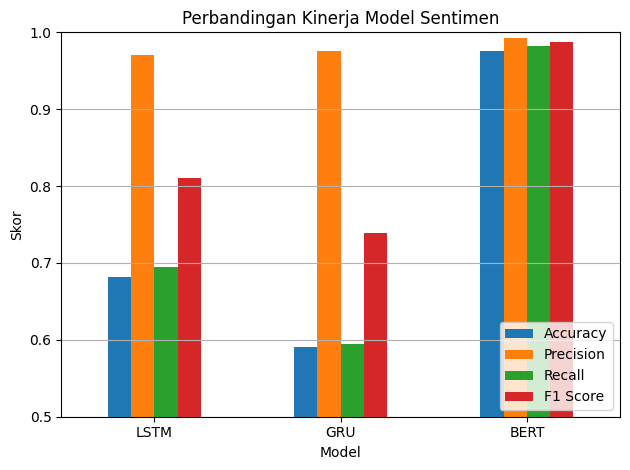

In [ ]:
# Visualisasi Perbandingan
plt.figure(figsize=(10,6))
results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(kind='bar')
plt.title("Perbandingan Kinerja Model Sentimen")
plt.ylabel("Skor")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()